c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


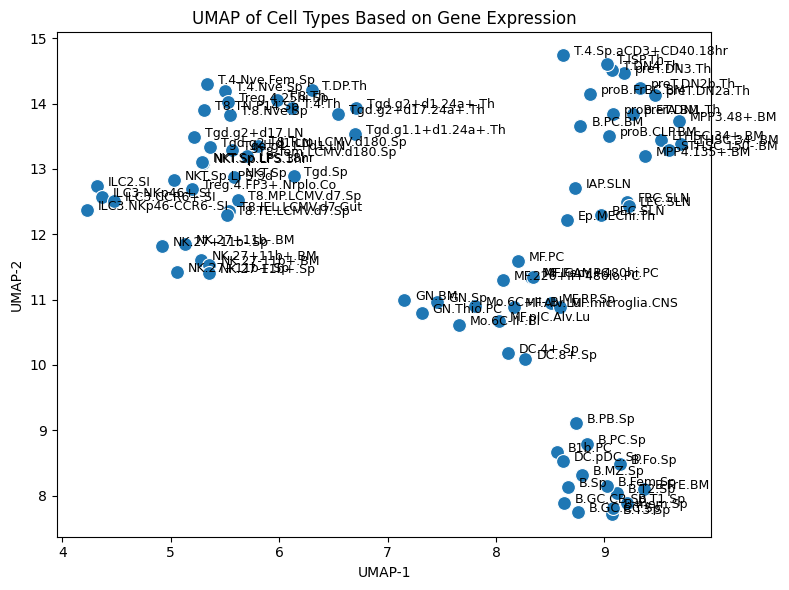

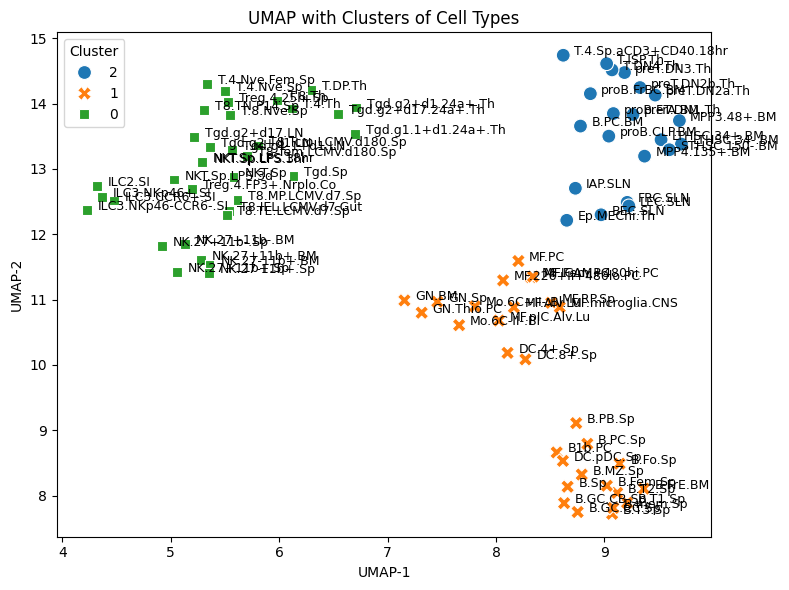

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

RNA_seq_path=r"C:\Users\helen\Downloads\datasets\mmc2.csv"
RNA_seq=pd.read_csv(RNA_seq_path,index_col=0)
RNA_seq_T=RNA_seq.T

RNA_seq_log = np.log1p(RNA_seq_T)  

scaler = StandardScaler()
RNA_seq_scaled = scaler.fit_transform(RNA_seq_log)

reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(RNA_seq_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], s=100)


for i, label in enumerate(RNA_seq_T.index):
    plt.text(umap_embedding[i, 0]+0.1, umap_embedding[i, 1], label, fontsize=9)

plt.title("UMAP of Cell Types Based on Gene Expression")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embedding)

umap_RNA_seq = pd.DataFrame(umap_embedding, columns=["UMAP1", "UMAP2"])
umap_RNA_seq["CellType"] = RNA_seq_T.index
umap_RNA_seq["Cluster"] = cluster_labels.astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_RNA_seq, x="UMAP1", y="UMAP2", hue="Cluster", style="Cluster", s=100, palette="tab10")

for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["CellType"], fontsize=9)

plt.title("UMAP with Clusters of Cell Types")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


